In [1]:
# %load "agent_tabular_ql.py"
"""Tabular QL agent"""
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import framework
import utils
import pdb

In [2]:
DEBUG = False

GAMMA = 0.5  # discounted factor
TRAINING_EP = 0.5  # epsilon-greedy parameter for training
TESTING_EP = 0.05  # epsilon-greedy parameter for testing
NUM_RUNS = 10
NUM_EPOCHS = 200
NUM_EPIS_TRAIN = 25  # number of episodes for training at each epoch
NUM_EPIS_TEST = 50  # number of episodes for testing
ALPHA = 0.1  # learning rate for training

ACTIONS = framework.get_actions()
OBJECTS = framework.get_objects()
NUM_ACTIONS = len(ACTIONS)
NUM_OBJECTS = len(OBJECTS)

In [3]:
# pragma: coderesponse template
def epsilon_greedy(state_1, state_2, q_func, epsilon):
    """Returns an action selected by an epsilon-Greedy exploration policy

    Args:
        state_1, state_2 (int, int): two indices describing the current state
        q_func (np.ndarray): current Q-function
        epsilon (float): the probability of choosing a random command

    Returns:
        (int, int): the indices describing the action/object to take
    """
    # TODO Your code here
    linear_arr = q_func[state_1,state_2].ravel()
    maxind = np.argmax(linear_arr)
    indices = np.array(range(len(linear_arr)))
    epsilon_each = epsilon/len(linear_arr)
    probabilities = np.array([epsilon_each]*len(linear_arr))
    probabilities[maxind] = probabilities[maxind]+(1-epsilon)
    sel_index = np.random.choice(indices,p=probabilities)
    action_index, object_index = np.unravel_index(sel_index,q_func[state_1,state_2].shape)
    return (action_index, object_index)

# pragma: coderesponse end

In [4]:
# pragma: coderesponse template
def tabular_q_learning(q_func, current_state_1, current_state_2, action_index,
                       object_index, reward, next_state_1, next_state_2,
                       terminal):
    """Update q_func for a given transition

    Args:
        q_func (np.ndarray): current Q-function
        current_state_1, current_state_2 (int, int): two indices describing the current state
        action_index (int): index of the current action
        object_index (int): index of the current object
        reward (float): the immediate reward the agent recieves from playing current command
        next_state_1, next_state_2 (int, int): two indices describing the next state
        terminal (bool): True if this epsiode is over

    Returns:
        None
    """
    # TODO Your code here
    if terminal:
        maxq = 0
    else:
        maxq = np.max(q_func[next_state_1,next_state_2])
        
    q_func[current_state_1, current_state_2, action_index,
           object_index] = (1-ALPHA)*q_func[current_state_1, current_state_2, action_index,
           object_index] + ALPHA*(reward + GAMMA*maxq)

    return None  # This function shouldn't return anything


# pragma: coderesponse end

In [5]:
# pragma: coderesponse template
def run_episode(for_training):
    """ Runs one episode
    If for training, update Q function
    If for testing, computes and return cumulative discounted reward

    Args:
        for_training (bool): True if for training

    Returns:
        None
    """
    epsilon = TRAINING_EP if for_training else TESTING_EP

    epi_reward = 0

    (current_room_desc, current_quest_desc, terminal) = framework.newGame()
    
    t = 0
    term = False
    while not term:
        current_room_ind = dict_room_desc[current_room_desc]
        quest_ind = dict_quest_desc[current_quest_desc]
        
        # Choose next action and execute
        (action_index, object_index) = epsilon_greedy(current_room_ind,quest_ind,q_func,epsilon)
        
        (next_room_desc, next_quest_desc, reward, terminal) = framework.step_game(current_room_desc,current_quest_desc,action_index,object_index)
        
        next_room_ind = dict_room_desc[next_room_desc]
        next_quest_ind = dict_quest_desc[next_quest_desc]
        
        if for_training:
            # update Q-function.
            tabular_q_learning(q_func, current_room_ind, quest_ind, action_index,
                       object_index, reward, next_room_ind, next_quest_ind,
                       terminal)

        if not for_training:
            # update reward
            epi_reward = epi_reward + (GAMMA**t)*reward

        # prepare next step
        t = t+1
        current_room_desc = next_room_desc
        current_quest_desc = next_quest_desc
        term = terminal
        
    if not for_training:
        return epi_reward


# pragma: coderesponse end

In [6]:
def run_epoch():
    """Runs one epoch and returns reward averaged over test episodes"""
    rewards = []
    for _ in range(NUM_EPIS_TRAIN):
        run_episode(for_training=True)

    for _ in range(NUM_EPIS_TEST):
        rewards.append(run_episode(for_training=False))

    return np.mean(np.array(rewards))


def run():
    """Returns array of test reward per epoch for one run"""
    global q_func
    q_func = np.zeros((NUM_ROOM_DESC, NUM_QUESTS, NUM_ACTIONS, NUM_OBJECTS))

    single_run_epoch_rewards_test = []
    pbar = tqdm(range(NUM_EPOCHS), ncols=80)
    for _ in pbar:
        single_run_epoch_rewards_test.append(run_epoch())
        pbar.set_description(
            "Avg reward: {:0.6f} | Ewma reward: {:0.6f}".format(
                np.mean(single_run_epoch_rewards_test),
                utils.ewma(single_run_epoch_rewards_test)))
    return single_run_epoch_rewards_test

Avg reward: 0.504568 | Ewma reward: 0.505726: 100%|█| 200/200 [00:03<00:00, 58.27it/s]
Avg reward: 0.491894 | Ewma reward: 0.533266: 100%|█| 200/200 [00:03<00:00, 54.40it/s]
Avg reward: 0.481838 | Ewma reward: 0.495790: 100%|█| 200/200 [00:03<00:00, 53.25it/s]
Avg reward: 0.481800 | Ewma reward: 0.489960: 100%|█| 200/200 [00:03<00:00, 52.76it/s]
Avg reward: 0.479357 | Ewma reward: 0.507493: 100%|█| 200/200 [00:03<00:00, 51.84it/s]
Avg reward: 0.494856 | Ewma reward: 0.509739: 100%|█| 200/200 [00:03<00:00, 53.94it/s]
Avg reward: 0.478339 | Ewma reward: 0.521816: 100%|█| 200/200 [00:03<00:00, 52.40it/s]
Avg reward: 0.488344 | Ewma reward: 0.514216: 100%|█| 200/200 [00:03<00:00, 59.07it/s]
Avg reward: 0.497536 | Ewma reward: 0.516160: 100%|█| 200/200 [00:03<00:00, 55.23it/s]
Avg reward: 0.497644 | Ewma reward: 0.513784: 100%|█| 200/200 [00:03<00:00, 54.90it/s]


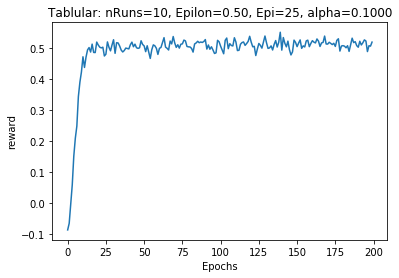

In [7]:
if __name__ == '__main__':
    # Data loading and build the dictionaries that use unique index for each state
    (dict_room_desc, dict_quest_desc) = framework.make_all_states_index()
    NUM_ROOM_DESC = len(dict_room_desc)
    NUM_QUESTS = len(dict_quest_desc)

    # set up the game
    framework.load_game_data()

    epoch_rewards_test = []  # shape NUM_RUNS * NUM_EPOCHS

    for _ in range(NUM_RUNS):
        epoch_rewards_test.append(run())

    epoch_rewards_test = np.array(epoch_rewards_test)

    x = np.arange(NUM_EPOCHS)
    fig, axis = plt.subplots()
    axis.plot(x, np.mean(epoch_rewards_test,
                         axis=0))  # plot reward per epoch averaged per run
    axis.set_xlabel('Epochs')
    axis.set_ylabel('reward')
    axis.set_title(('Tablular: nRuns=%d, Epilon=%.2f, Epi=%d, alpha=%.4f' %
                    (NUM_RUNS, TRAINING_EP, NUM_EPIS_TRAIN, ALPHA)))
    plt.show()